In [1]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import glob, os
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from tqdm import tqdm
import datetime
import glob, os
import fastavro
from fastavro import reader, writer
import io
import gzip
import numpy as np
import torch.nn as nn

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split

from scipy import ndimage
import sqlite3
import joblib

from winterrb.utils import pick_alert, make_triplet, rotate_triplet, plot_triplet
from winterrb.model import WINTERNet
from winterrb.paths import data_dir, train_class_path, model_dir
from pathlib import Path
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torchinfo import summary
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np

In [2]:
model_name = "winterrb_v1_0_0_weights"

### Training dataset

In [3]:
# read csv file containing properties of all cutouts
rbdf = pd.read_csv(train_class_path)

# separate reals and bogus
real_df = rbdf[rbdf["reclass"] == 1]

# include all yin-yangs
bogus_df = pd.concat(
    [
        rbdf[rbdf["reclass"] == 3].sample(400),
        rbdf[
            (rbdf["reclass"] > 1) & (rbdf["reclass"] != 5) & (rbdf["reclass"] != 3)
        ].sample(1300),
    ]
)

# bad astrometry
# bogus_df = rbdf[rbdf['reclass'] == 5]

In [4]:
print(
    f"Number of real sources: {len(real_df)}, number of bogus sources: {len(bogus_df)}"
)

Number of real sources: 392, number of bogus sources: 1700


In [5]:
avro_dir = data_dir.joinpath("train_data")
real_df.loc[:, ["path"]] = [avro_dir.joinpath(Path(x).name) for x in real_df["path"]]
bogus_df.loc[:, ["path"]] = [avro_dir.joinpath(Path(x).name) for x in bogus_df["path"]]

In [6]:
for df in [real_df, bogus_df]:
    mask = np.array([x.exists() for x in df["path"]]).astype(bool)
    print(mask.sum(), (~mask).sum(), len(mask))

392 0 392
1700 0 1700


In [7]:
# #visualise reals
# idxs = real_df.sample(n = 5).index
# candids = real_df['candid'].loc[idxs].to_numpy()
# filenames = real_df.loc[idxs, 'path'].values
# for i in range(len(candids)):
#     rec = pick_alert(filenames[i], candids[i])[0]
#     triplet = make_triplet(rec, normalize = True)
#     plot_triplet(triplet)

In [8]:
# #visualise bogus
# idxs = bogus_df.sample(n = 5).index
# candids = bogus_df['candid'].loc[idxs].to_numpy()
# filenames = bogus_df.loc[idxs, 'path'].values
# for i in range(len(candids)):
#     rec = pick_alert(filenames[i], candids[i])[0]
#     triplet = make_triplet(rec, normalize = True)
#     plot_triplet(triplet)

In [9]:
print("Stacking reals")
cut_real = np.zeros(shape=(len(real_df) * 4, 81, 81, 3))
missing_reals = []
for i in tqdm(range(len(real_df))):
    candid = real_df["candid"].iloc[i]
    avro_file = real_df["path"].iloc[i]
    try:
        rec = pick_alert(avro_file, candid)[0]
        triplet = make_triplet(rec, normalize=True)
        t90, t180, t270 = rotate_triplet(triplet)
        cut_real[4 * i] = triplet
        cut_real[4 * i + 1] = t90
        cut_real[4 * i + 2] = t180
        cut_real[4 * i + 3] = t270
    except:
        missing_reals.extend([4 * i, 4 * i + 1, 4 * i + 2, 4 * i + 3])

print("Stacking bogus")
nb = len(bogus_df)  # 1500
cut_bogus = np.zeros(shape=(nb, 81, 81, 3))
missing_bogus = []
for i in tqdm(range(len(bogus_df.sample(nb)))):
    candid = bogus_df["candid"].iloc[i]
    avro_file = bogus_df["path"].iloc[i]
    try:
        rec = pick_alert(avro_file, candid)[0]
        triplet = make_triplet(rec, normalize=True)
        cut_bogus[i] = triplet
    except:
        missing_bogus.append(i)

Stacking reals


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 392/392 [00:02<00:00, 159.51it/s]


Stacking bogus


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1700/1700 [00:02<00:00, 574.42it/s]


In [10]:
len(missing_reals), len(missing_bogus)

(0, 0)

In [11]:
cut_real = np.delete(cut_real, missing_reals, 0)
cut_bogus = np.delete(cut_bogus, missing_bogus, 0)

In [12]:
np.isnan(cut_real).sum(), np.isnan(cut_bogus).sum()

(0, 0)

In [13]:
labels_real = np.ones(shape=len(cut_real))
labels_bogus = np.zeros(shape=len(cut_bogus))

In [14]:
cut = np.concatenate((cut_real, cut_bogus), axis=0)
labels = np.concatenate((labels_real, labels_bogus), axis=0)

print(f"Number of real sources: {len(cut_real)}")
print(f"Number of bogus sources: {len(cut_bogus)}")
print(f"Total training samples: {len(cut)}")

Number of real sources: 1568
Number of bogus sources: 1700
Total training samples: 3268


### Training the model

In [15]:
test_split = 0.1
random_state = 95

# make train and test masks:
_, _, mask_train, mask_test = train_test_split(
    list(range(len(cut))),
    list(range(len(cut))),
    test_size=test_split,
    random_state=random_state,
    shuffle=True,
)
masks = {"training": mask_train, "test": mask_test}

In [16]:
# create training and testing samples
x_train, y_train = cut[mask_train], labels[mask_train]
x_test, y_test = cut[mask_test], labels[mask_test]

print(f"Training samples {np.shape(x_train)}, testing samples {np.shape(x_test)}")

Training samples (2941, 81, 81, 3), testing samples (327, 81, 81, 3)


In [17]:
loss = "binary_crossentropy"
optimizer = "adam"
epochs = 50
patience = 50
validation_split = 0.1
class_weight = True
batch_size = 64

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=validation_split, random_state=0
)

In [18]:


class CustomDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]

        if self.transform:
            x = self.transform(x)

        return x, y


data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomHorizontalFlip(data_augmentation['horizontal_flip']),
            # transforms.RandomVerticalFlip(data_augmentation['vertical_flip']),
            # transforms.RandomRotation(data_augmentation['rotation_range']),
            transforms.ToTensor(),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    ),
}


class CustomDataLoader:
    def __init__(self, x_train, y_train, batch_size, validation_split):
        self.batch_size = batch_size
        self.validation_split = validation_split

        # Splitting data into training and validation
        split_index = int((1 - self.validation_split) * len(x_train))
        x_train, x_val = x_train[:split_index], x_train[split_index:]
        y_train, y_val = y_train[:split_index], y_train[split_index:]

        self.train_dataset = CustomDataset(
            x_train, y_train, transform=data_transforms["train"]
        )
        self.val_dataset = CustomDataset(x_val, y_val, transform=data_transforms["val"])

    def get_loaders(self):
        train_loader = DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True
        )
        val_loader = DataLoader(
            self.val_dataset, batch_size=self.batch_size, shuffle=False
        )
        return train_loader, val_loader


# Creating data loaders
custom_data_loader = CustomDataLoader(x_train, y_train, batch_size, validation_split)
training_generator, validation_generator = custom_data_loader.get_loaders()

In [19]:
image_shape = x_train.shape[1:]

n_classes = 1
print("Input image shape:", image_shape)
print("Class weight: ", class_weight)

Input image shape: (81, 81, 3)
Class weight:  True


In [20]:
net = WINTERNet()

optimizer = optim.Adam(net.parameters(), lr=8e-4, betas=(0.9, 0.999), eps=1e-07)

summary(
    net,
    input_size=(1, 3, 81, 81),
    col_names=["input_size", "output_size", "num_params"],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
WINTERNet                                [1, 3, 81, 81]            [1, 1]                    --
├─Conv2d: 1-1                            [1, 3, 81, 81]            [1, 16, 81, 81]           448
├─Conv2d: 1-2                            [1, 16, 81, 81]           [1, 16, 81, 81]           2,320
├─Conv2d: 1-3                            [1, 16, 81, 81]           [1, 16, 81, 81]           2,320
├─MaxPool2d: 1-4                         [1, 16, 81, 81]           [1, 16, 40, 40]           --
├─BatchNorm2d: 1-5                       [1, 16, 40, 40]           [1, 16, 40, 40]           32
├─Dropout2d: 1-6                         [1, 16, 40, 40]           [1, 16, 40, 40]           --
├─Conv2d: 1-7                            [1, 16, 40, 40]           [1, 32, 40, 40]           4,640
├─Conv2d: 1-8                            [1, 32, 40, 40]           [1, 32, 40, 40]           9,248
├─Conv2d: 1-9         

In [21]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

# Training loop
for epoch in tqdm(range(epochs)):
    net.train()  # Set the model to train mode
    running_loss = 0.0

    # Iterate over the batches from the training generator
    for inputs, labels in training_generator:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs.T[0].to(float), labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(training_generator.dataset)

print("Finished Training")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [20:45<00:00, 24.91s/it]

Finished Training


In [22]:
torch.save(net.state_dict(), model_dir / f"{model_name}.pth")

### Feature maps

In [23]:
# model = tf.keras.models.load_model('gitdrb_VGG6_git_20230815_173158.keras')
# model = tf.keras.models.load_model('winterdrb_VGG6_git_20240312_061414.keras')
# model = tf.keras.models.load_model('winterdrb_VGG6_git_20240313_163534.keras') - best model
# model = tf.keras.models.load_model('winterdrb_VGG6_git_20240410_051006.keras')
# model = tf.keras.models.load_model('winterdrb_v2_VGG6_git_20240423_122053.keras')
# fmodel = tf.keras.Model(inputs=model.inputs , outputs=model.layers[0].output)

In [24]:
# img =  np.copy(cut[50])
# img_ = np.expand_dims(img, axis = 0)

In [25]:
# feature_maps = fmodel.predict(img_)

In [26]:
# plt.figure(figsize = (16,16))
# square = [4, 4]
# ix = 1
# for _ in range(square[0]):
#     for _ in range(square[1]):
#         # specify subplot and turn of axis
#         ax = plt.subplot(square[0], square[0], ix)
#         ax.set_xticks([])
#         ax.set_yticks([])
#         # plot filter channel in grayscale
#         plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
#         ix += 1
#         # show the figure
# plt.show()

### Performance metrics

In [27]:
model = net.eval()

In [28]:
x_test_reshaped = np.transpose(x_test, (0, 3, 1, 2))
x_train_reshaped = np.transpose(x_train, (0, 3, 1, 2))

In [29]:
y_true = y_test

# Pass the test data through the model
with torch.no_grad():
    outputs = model(torch.from_numpy(x_test_reshaped))

y_pred_score = outputs.float().numpy()

In [30]:
# Pass the test data through the model
with torch.no_grad():
    outputs = model(torch.from_numpy(x_train_reshaped))

train_pred_score = outputs.float().numpy()

In [31]:
train_true = y_train

In [32]:
cutoff = 0.5
train_y_pred = np.copy(train_pred_score)
train_y_pred[train_y_pred < cutoff] = 0
train_y_pred[train_y_pred > cutoff] = 1

In [33]:
acc = accuracy_score(train_true, train_y_pred)
f1 = f1_score(train_true, train_y_pred)

print(f"Accuracy: {acc}, F1-score: {f1}")

Accuracy: 0.9879062736205594, F1-score: 0.9872


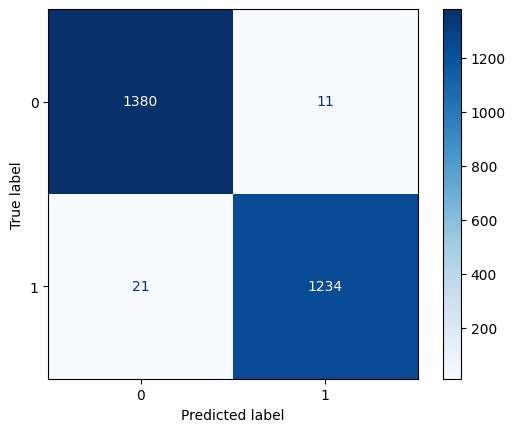

In [34]:
# confusion matrix
cm = confusion_matrix(train_true, train_y_pred.flatten())
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.show()

In [35]:
cutoff = 0.2
y_pred = np.copy(y_pred_score)
y_pred[y_pred < cutoff] = 0
y_pred[y_pred > cutoff] = 1

In [36]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {acc}, F1-score: {f1}")

Accuracy: 0.9418960244648318, F1-score: 0.9415384615384615


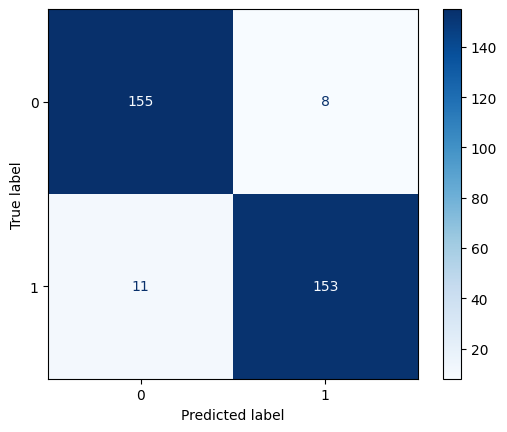

In [37]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred.flatten())
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.show()

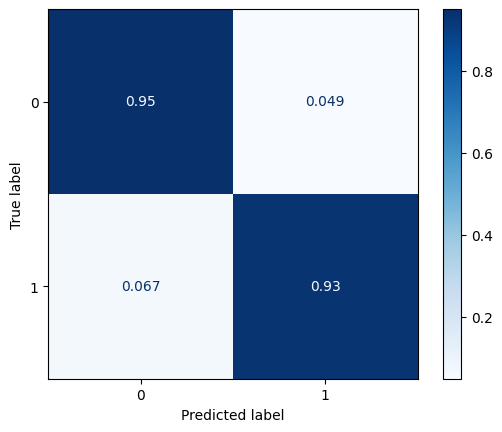

In [38]:
# normalised confusion matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
ConfusionMatrixDisplay(cm_norm).plot(cmap="Blues")
plt.show()

In [39]:
miscl_mask = y_true - y_pred.flatten()
false_pos = miscl_mask < 0
false_neg = miscl_mask > 0
print(
    f"False positives: {len(x_test[false_pos])}, False negatives: {len(x_test[false_neg])}"
)

False positives: 8, False negatives: 11


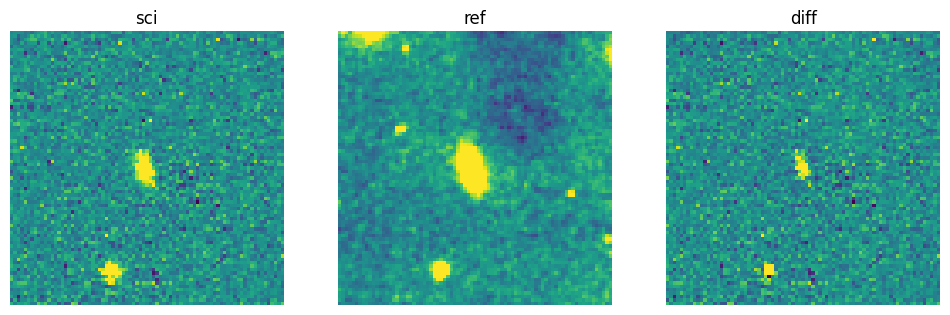

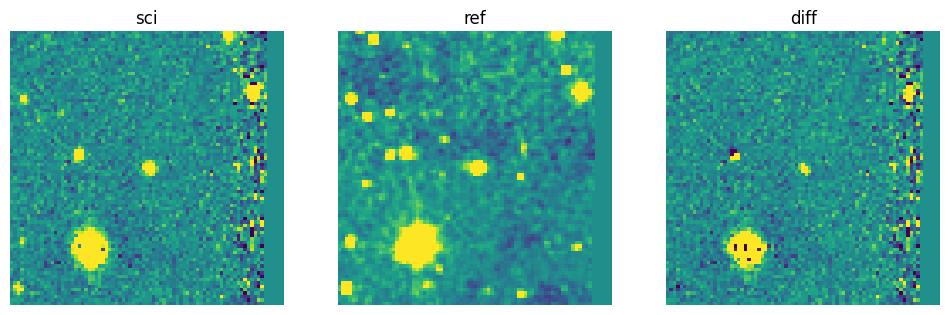

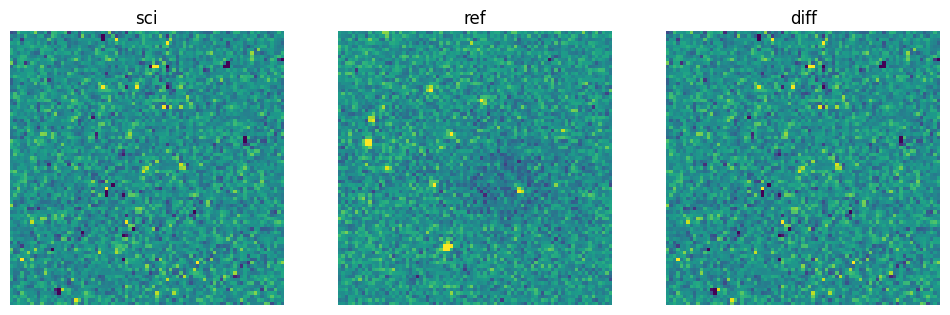

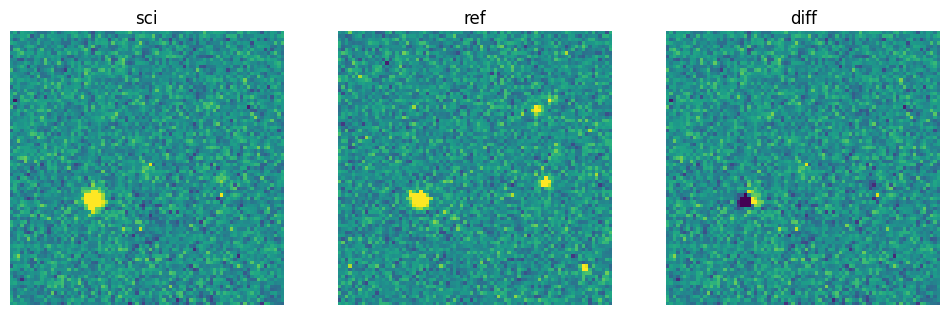

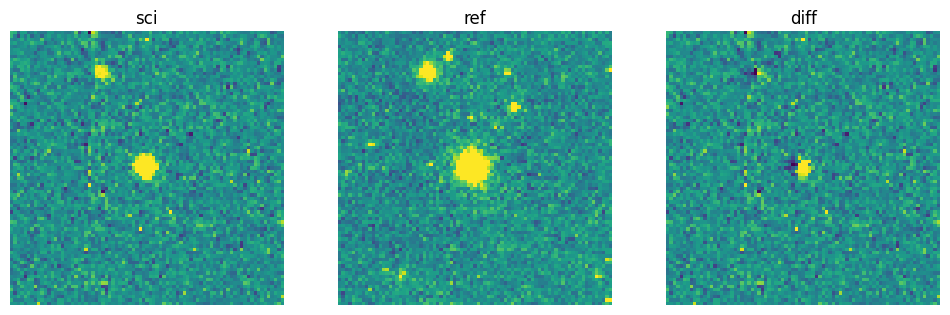

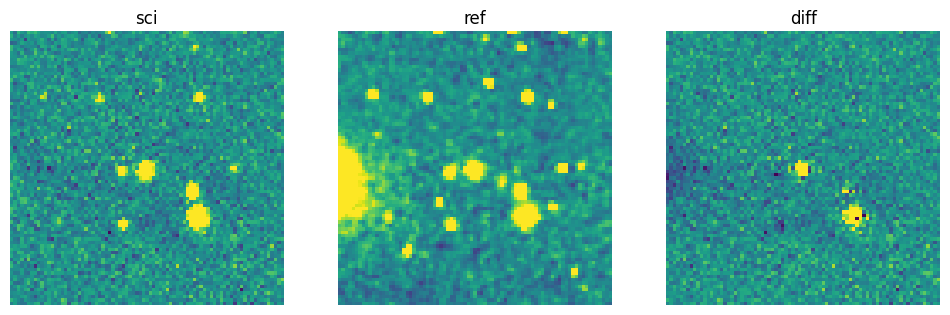

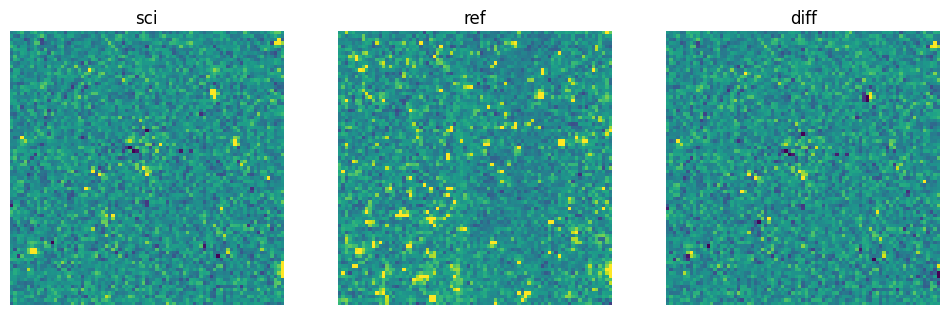

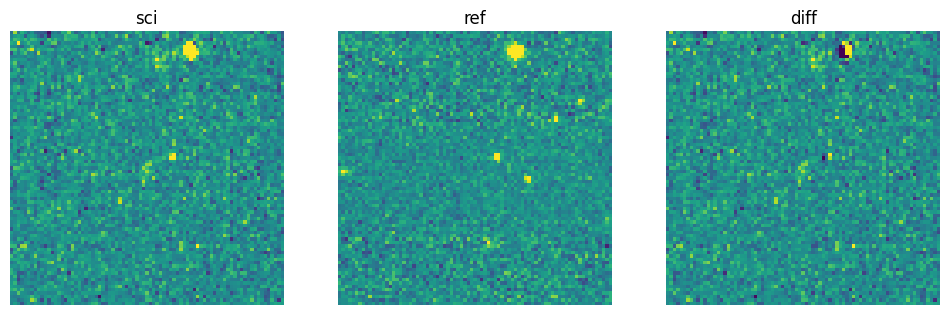

In [40]:
for fp in x_test[false_pos]:
    plot_triplet(fp)

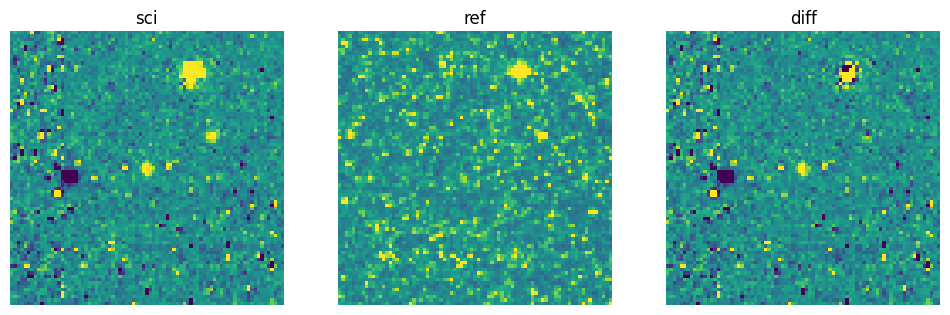

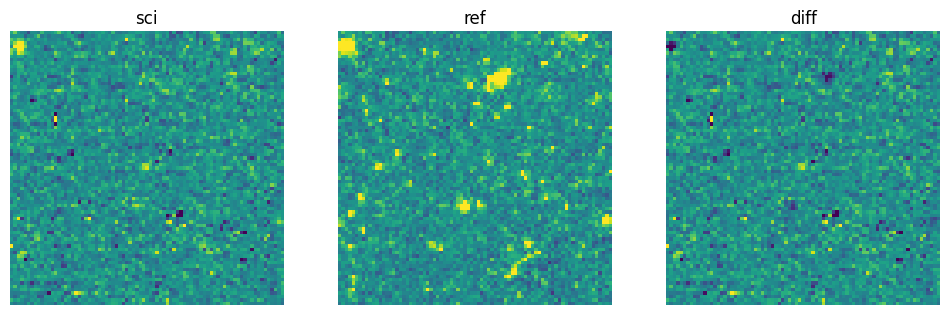

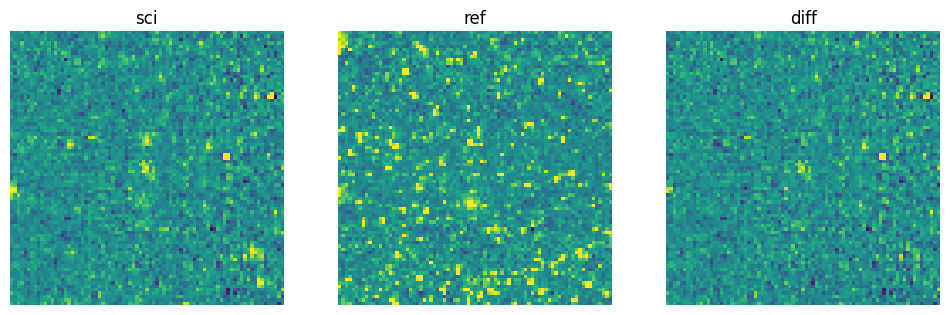

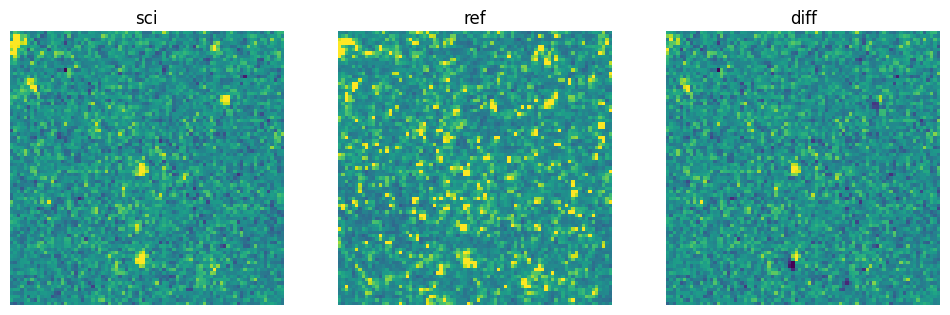

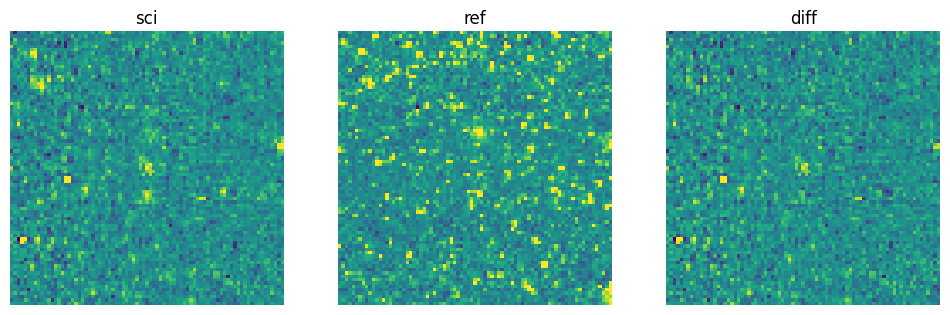

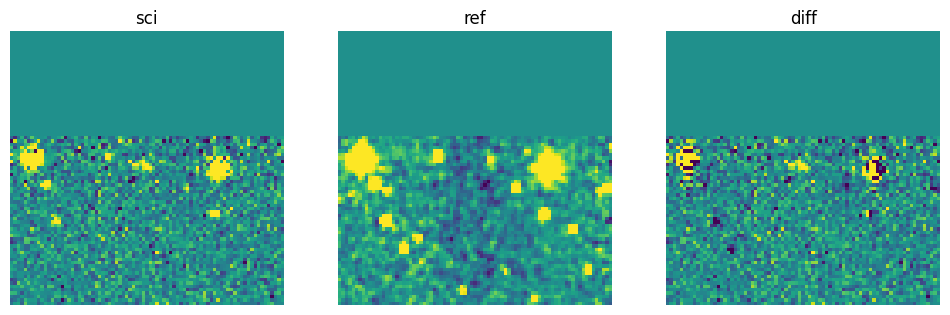

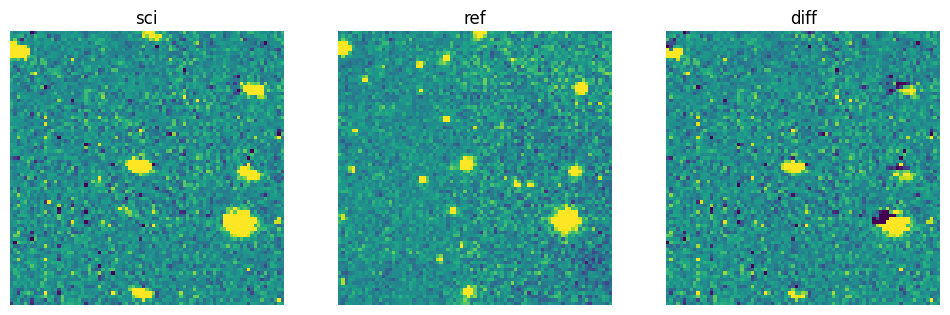

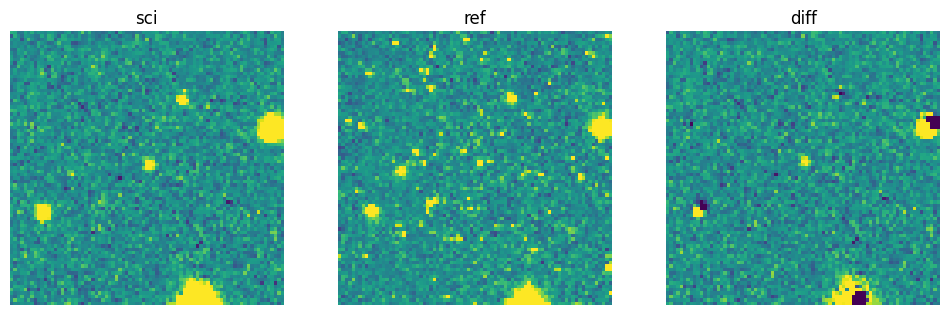

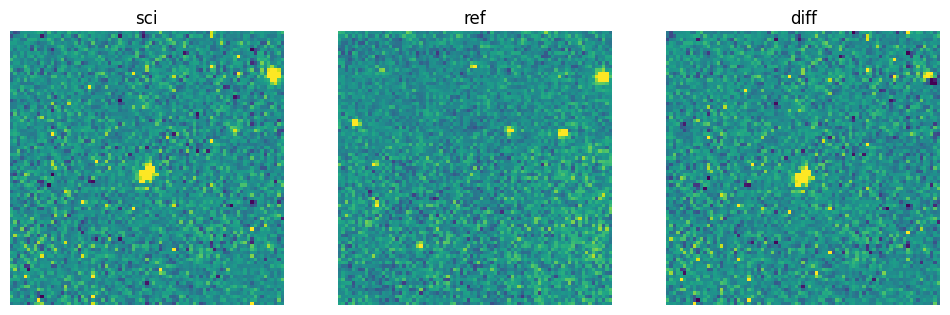

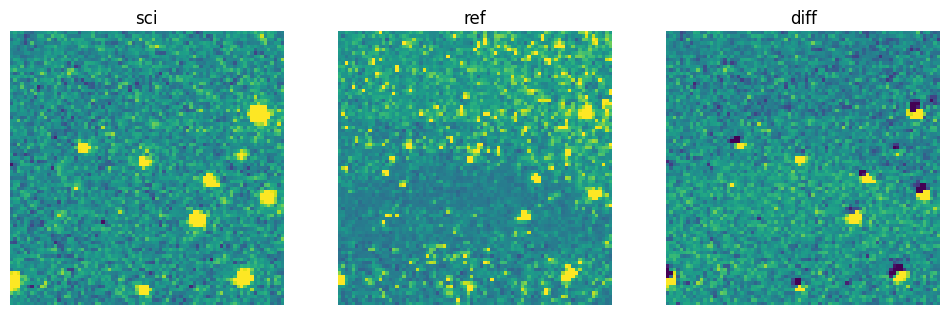

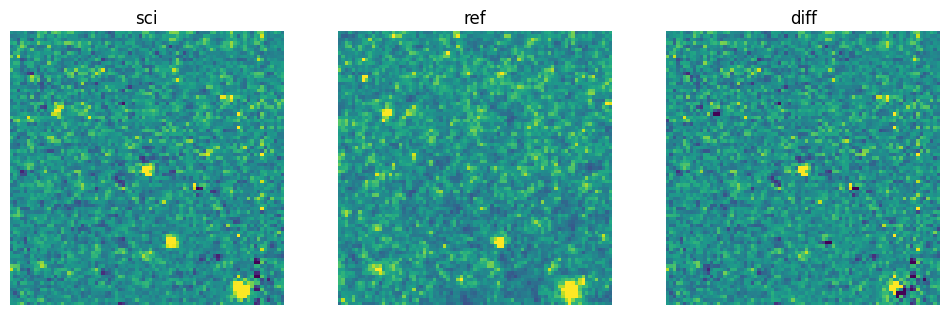

In [41]:
for fn in x_test[false_neg]:
    plot_triplet(fn)

In [42]:
rbbins = np.arange(-0.0001, 1.0001, 0.0001)
h_b, e_b = np.histogram(y_pred_score[y_true == 0], bins=rbbins, density=True)
h_b_c = np.cumsum(h_b)
h_r, e_r = np.histogram(y_pred_score[y_true == 1], bins=rbbins, density=True)
h_r_c = np.cumsum(h_r)

0.5 8.536585365853137 4.294478527607848
0.23 6.707317073170172 4.907975460122904
0.001 3.6585365853655265 14.723926380368413


/var/folders/hd/1411jr114w9cvmmnw9mx0xvr0000gn/T/ipykernel_80614/3153236484.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


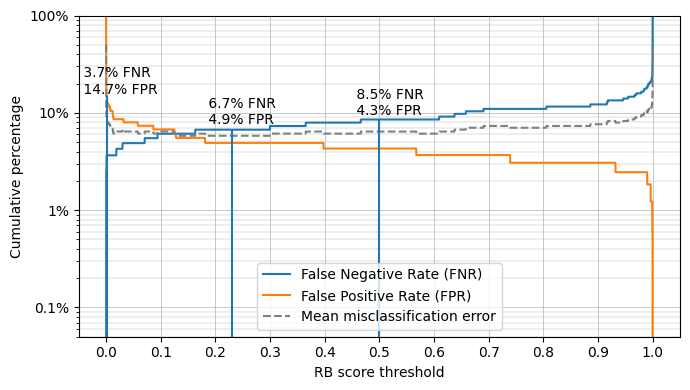

In [43]:
fig = plt.figure(figsize=(7, 4), dpi=100)
ax = fig.add_subplot(111)

rb_thres = np.array(list(range(len(h_b)))) / len(h_b)

ax.plot(
    rb_thres, h_r_c / np.max(h_r_c), label="False Negative Rate (FNR)", linewidth=1.5
)
ax.plot(
    rb_thres,
    1 - h_b_c / np.max(h_b_c),
    label="False Positive Rate (FPR)",
    linewidth=1.5,
)

mmce = (h_r_c / np.max(h_r_c) + 1 - h_b_c / np.max(h_b_c)) / 2
ax.plot(
    rb_thres,
    mmce,
    "--",
    label="Mean misclassification error",
    color="gray",
    linewidth=1.5,
)

ax.set_xlim([-0.05, 1.05])

ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))

# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax.set_yscale("log")
ax.set_ylim([5e-4, 1])
vals = ax.get_yticks()
ax.set_yticklabels(
    ["{:,.1%}".format(x) if x < 0.01 else "{:,.0%}".format(x) for x in vals]
)

# thresholds:
thrs = [0.5, 0.23, 0.001]
for t in thrs:
    m_t = rb_thres < t
    fnr = np.array(h_r_c / np.max(h_r_c))[m_t][-1]
    fpr = np.array(1 - h_b_c / np.max(h_b_c))[m_t][-1]
    print(t, fnr * 100, fpr * 100)
    # ax.vlines(t_1, 0, 1.1)
    ax.vlines(t, 0, max(fnr, fpr))
    ax.text(
        t - 0.05,
        max(fnr, fpr) + 0.01,
        f" {fnr*100:.1f}% FNR\n {fpr*100:.1f}% FPR",
        fontsize=10,
    )

ax.set_xlabel("RB score threshold")
ax.set_ylabel("Cumulative percentage")
ax.legend(loc="lower center")
ax.grid(True, which="major", linewidth=0.5)
ax.grid(True, which="minor", linewidth=0.3)
plt.tight_layout()

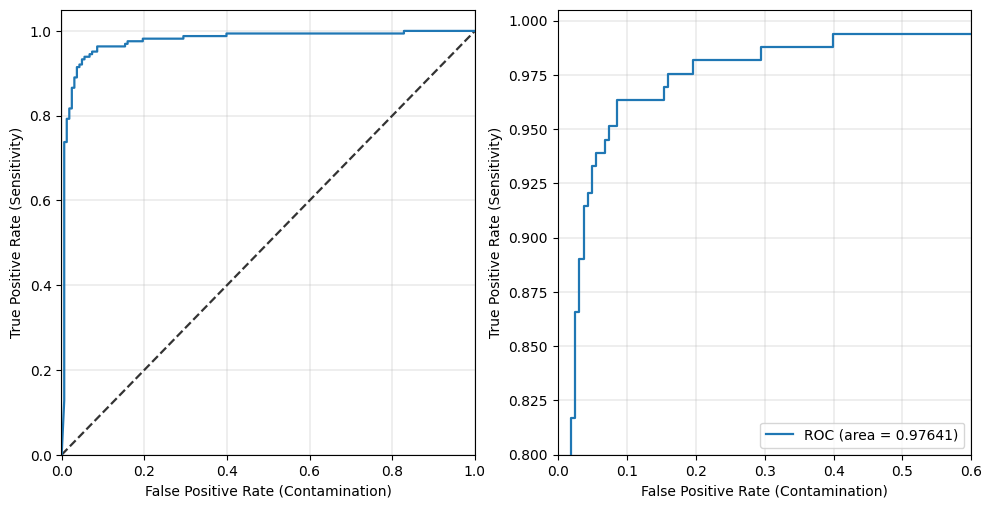

In [44]:
fig = plt.figure(figsize=(14, 5), dpi=100)
fig.subplots_adjust(
    bottom=0.09, left=0.05, right=0.70, top=0.98, wspace=0.2, hspace=0.2
)
lw = 1.6
# ROCs
ax = fig.add_subplot(1, 2, 1)
# zoomed ROCs
ax2 = fig.add_subplot(1, 2, 2)

ax.plot([0, 1], [0, 1], color="#333333", lw=lw, linestyle="--")
ax.set_xlim([-0.001, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate (Contamination)")
ax.set_ylabel("True Positive Rate (Sensitivity)")
# ax.legend(loc="lower right")
# ax.legend(loc="best")
ax.grid(True, linewidth=0.3)

# ax2.set_xlim([0.0, .2])
# ax2.set_ylim([0.8, 1.0])
ax2.set_xlim([-0.001, 0.6])
ax2.set_ylim([0.8, 1.005])
ax2.set_xlabel("False Positive Rate (Contamination)")
ax2.set_ylabel("True Positive Rate (Sensitivity)")
# ax.legend(loc="lower right")
ax2.grid(True, linewidth=0.3)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_score.flatten())
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=lw)
ax2.plot(fpr, tpr, lw=lw, label=f"ROC (area = {roc_auc:.5f})")
ax2.legend(loc="lower right")